# Recognize named entities on Twitter with LSTMs

In this assignment, you will use a recurrent neural network to solve Named Entity Recognition (NER) problem. NER is a common task in natural language processing systems. It serves for extraction such entities from the text as persons, organizations, locations, etc. In this task you will experiment to recognize named entities from Twitter.

For example, we want to extract persons' and organizations' names from the text. Than for the input text:

    Ian Goodfellow works for Google Brain

a NER model needs to provide the following sequence of tags:

    B-PER I-PER    O     O   B-ORG  I-ORG

Where *B-* and *I-* prefixes stand for the beginning and inside of the entity, while *O* stands for out of tag or no tag. Markup with the prefix scheme is called *BIO markup*. This markup is introduced for distinguishing of consequent entities with similar types.

A solution of the task will be based on neural networks, particularly, on Bi-Directional Long Short-Term Memory Networks (Bi-LSTMs).

### Libraries

For this task you will need the following libraries:
 - [Tensorflow](https://www.tensorflow.org) — an open-source software library for Machine Intelligence.
 
In this assignment, we use Tensorflow 1.15.0. You can install it with pip:

    !pip install tensorflow==1.15.0
     
 - [Numpy](http://www.numpy.org) — a package for scientific computing.
 
If you have never worked with Tensorflow, you would probably need to read some tutorials during your work on this assignment, e.g. [this one](https://www.tensorflow.org/tutorials/recurrent) could be a good starting point. 

### Data

The following cell will download all data required for this assignment into the folder `week2/data`.

In [2]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    ! wget https://raw.githubusercontent.com/hse-aml/natural-language-processing/master/setup_google_colab.py -O setup_google_colab.py
    import setup_google_colab
    setup_google_colab.setup_week2()

import sys
sys.path.append("..")
from common.download_utils import download_week2_resources

download_week2_resources()

--2020-08-30 04:04:25--  https://raw.githubusercontent.com/hse-aml/natural-language-processing/master/setup_google_colab.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1939 (1.9K) [text/plain]
Saving to: ‘setup_google_colab.py’

setup_google_colab. 100%[===================>]   1.89K  --.-KB/s    in 0s      

2020-08-30 04:04:25 (33.0 MB/s) - ‘setup_google_colab.py’ saved [1939/1939]

File data/train.txt is already downloaded.
File data/validation.txt is already downloaded.
File data/test.txt is already downloaded.


### Load the Twitter Named Entity Recognition corpus

We will work with a corpus, which contains tweets with NE tags. Every line of a file contains a pair of a token (word/punctuation symbol) and a tag, separated by a whitespace. Different tweets are separated by an empty line.

The function *read_data* reads a corpus from the *file_path* and returns two lists: one with tokens and one with the corresponding tags. You need to complete this function by adding a code, which will replace a user's nickname to `<USR>` token and any URL to `<URL>` token. You could think that a URL and a nickname are just strings which start with *http://* or *https://* in case of URLs and a *@* symbol for nicknames.

In [3]:
import re
import numpy as np

def read_data(file_path):
    tokens = []
    tags = []
    
    tweet_tokens = []
    tweet_tags = []
    for line in open(file_path, encoding='utf-8'):
        line = line.strip()
        if not line:
            if tweet_tokens:
                tokens.append(tweet_tokens)
                tags.append(tweet_tags)
            tweet_tokens = []
            tweet_tags = []
        else:
            token, tag = line.split()
            token =  re.sub(r'\b(http|https|ftp)://(\w*.\w*)+', '<URL>', token) 
            token = re.sub('@\w+', '<USR>', token)
            tweet_tokens.append(token)
            tweet_tags.append(tag)
    return tokens, tags

And now we can load three separate parts of the dataset:
 - *train* data for training the model;
 - *validation* data for evaluation and hyperparameters tuning;
 - *test* data for final evaluation of the model.

In [4]:
train_tokens, train_tags = read_data('data/train.txt')
validation_tokens, validation_tags = read_data('data/validation.txt')
test_tokens, test_tags = read_data('data/test.txt')

You should always understand what kind of data you deal with. For this purpose, you can print the data running the following cell:

In [5]:
for i in range(3):
    for token, tag in zip(train_tokens[i], train_tags[i]):
        print('%s\t%s' % (token, tag))
    print()

RT	O
<USR>	O
:	O
Online	O
ticket	O
sales	O
for	O
Ghostland	B-musicartist
Observatory	I-musicartist
extended	O
until	O
6	O
PM	O
EST	O
due	O
to	O
high	O
demand	O
.	O
Get	O
them	O
before	O
they	O
sell	O
out	O
...	O

Apple	B-product
MacBook	I-product
Pro	I-product
A1278	I-product
13.3	I-product
"	I-product
Laptop	I-product
-	I-product
MD101LL/A	I-product
(	O
June	O
,	O
2012	O
)	O
-	O
Full	O
read	O
by	O
eBay	B-company
<URL>	O
<URL>	O

Happy	O
Birthday	O
<USR>	O
!	O
May	O
Allah	B-person
s.w.t	O
bless	O
you	O
with	O
goodness	O
and	O
happiness	O
.	O



### Prepare dictionaries

To train a neural network, we will use two mappings: 
- {token}$\to${token id}: address the row in embeddings matrix for the current token;
- {tag}$\to${tag id}: one-hot ground truth probability distribution vectors for computing the loss at the output of the network.

Now you need to implement the function *build_dict* which will return {token or tag}$\to${index} and vice versa. 

for tokens in train_tokens:
    for token in tokens:
        if token not in g: 
            g[token]=k 
            k += 1
            id.append(token)

In [6]:
from collections import defaultdict, Counter

In [7]:
def build_dict(tokens_or_tags, special_tokens):
    """
        tokens_or_tags: a list of lists of tokens or tags
        special_tokens: some special tokens
    """
    # Create a dictionary with default value 0
    tok2idx = defaultdict(lambda: 0)
    idx2tok = []
    i=0   
    for token in special_tokens:
        tok2idx[token] = i
        idx2tok.append(token)
        i+=1
    for tokens in tokens_or_tags:
        for token in tokens:
            if token not in tok2idx:
                tok2idx[token] = i
                idx2tok.append(token)
                i+=1
    return tok2idx, idx2tok


After implementing the function *build_dict* you can make dictionaries for tokens and tags. Special tokens in our case will be:
 - `<UNK>` token for out of vocabulary tokens;
 - `<PAD>` token for padding sentence to the same length when we create batches of sentences.

In [8]:
special_tokens = ['<UNK>', '<PAD>']
special_tags = ['O']

# Create dictionaries 
token2idx, idx2token = build_dict(train_tokens + validation_tokens, special_tokens)
tag2idx, idx2tag = build_dict(train_tags, special_tags)

In [9]:
num_classes = len(tag2idx) # no of unique classes
num_words = len(token2idx) # no of unique words
classes = list(tag2idx.keys())

In [10]:
classes

['O',
 'B-musicartist',
 'I-musicartist',
 'B-product',
 'I-product',
 'B-company',
 'B-person',
 'B-other',
 'I-other',
 'B-facility',
 'I-facility',
 'B-sportsteam',
 'B-geo-loc',
 'I-geo-loc',
 'I-company',
 'I-person',
 'B-movie',
 'I-movie',
 'B-tvshow',
 'I-tvshow',
 'I-sportsteam']

In [11]:
def words2idxs(tokens_list):
    return [token2idx[word] for word in tokens_list]

def tags2idxs(tags_list):
    return [tag2idx[tag] for tag in tags_list]

def idxs2words(idxs):
    return [idx2token[idx] for idx in idxs]

def idxs2tags(idxs):
    return [idx2tag[idx] for idx in idxs]

# Tensorflow 2.0 upgrade

## Training 

In [12]:
!pip install livelossplot
import matplotlib.pyplot as plt
from tensorflow.keras import Model,Input
from tensorflow.keras.layers import Bidirectional ,LSTM, Dense,Flatten, Embedding, TimeDistributed,BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.initializers import glorot_uniform, Identity
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot import PlotLossesKeras
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.optimizers.schedules import ExponentialDecay


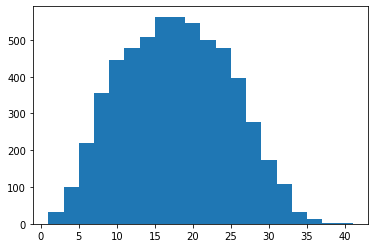

In [12]:
"""
Heuristic to check how much max length would be good for padded sentence
"""
plt.hist([len(i) for i in train_tokens ], bins=20)
plt.show()

In [13]:
"""
Build and pads tokens 

"""

max_len = 45
def pad_data(token_to_index, tokens, tag_to_index, tags, max_len=max_len):
    X = [[token_to_index[word] for word in sent] for sent in tokens]
    X = pad_sequences(sequences=X, maxlen=max_len, padding='post', value=num_words-1)

    y = [[tag_to_index[tag] for tag in tags] for tags in tags]
    y = pad_sequences(sequences=y, maxlen=max_len, padding='post', value=tag_to_index['O'])
    y = to_categorical(y, num_classes=num_classes)
    return X, y


X_train, y_train = pad_data(token2idx, train_tokens, tag2idx, train_tags, max_len=40)
X_validation, y_validation = pad_data(token2idx, validation_tokens, tag2idx, validation_tags,max_len=40)
X_test, y_test = pad_data(token2idx, test_tokens, tag2idx, test_tags, max_len=40)

In [14]:
#build model

def build_model(optim, input_dim=num_words, output_dim=max_len):
    input = Input(shape=(None,))
    embd = Embedding(input_dim=input_dim, output_dim=output_dim, input_length=output_dim, mask_zero=True )(input)
    m = Bidirectional(LSTM(units=100,  return_sequences=True))(embd)
    m = Bidirectional(LSTM(units=100, return_sequences=True))(m)
    m = Bidirectional(LSTM(units=100, return_sequences=True))(m)
    m = Dense(units=num_classes, activation='softmax')(m)
    m = Model(input, m)
    m.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy'])
    m.summary()
    return m


In [25]:
# model1 adam

lr_schedule = ExponentialDecay(
initial_learning_rate=1e-2,
decay_steps=10000,
decay_rate=0.9
)
optimizer = Adam(learning_rate=lr_schedule)
model1 = build_model(optim=optimizer)

models = {}
optims = ['sgd','rmsprop','nadam', 'adadelta', 'adagrad','adamax', 'ftrl']

for o in optims:
    models[o] = build_model(optim=o)


Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_7 (Embedding)      (None, None, 45)          922185    
_________________________________________________________________
bidirectional_19 (Bidirectio (None, None, 200)         116800    
_________________________________________________________________
bidirectional_20 (Bidirectio (None, None, 200)         240800    
_________________________________________________________________
bidirectional_21 (Bidirectio (None, None, 200)         240800    
_________________________________________________________________
dense_6 (Dense)              (None, None, 21)          4221      
Total params: 1,524,806
Trainable params: 1,524,806
Non-trainable params: 0
___________________________________________

In [15]:
#evaluation functions
def evaluate(m):
    train_loss, train_acc = m.evaluate(X_train, y_train, verbose=0)
    test_loss, test_acc = m.evaluate(X_test,y_test, verbose=0)
    validation_loss, validation_acc = m.evaluate(X_validation,y_validation, verbose=0)
    test_results = predict(m, test_tokens, test_tags)
    print(f"Training accuracy: {train_acc} Training loss:  {train_loss}\n")
    print(f"Validation accuracy: {validation_acc} Validation loss: {validation_loss}\n")
    print(f"Testing accuracy: {test_acc} Testing loss: {train_loss}")

from evaluation import precision_recall_f1

def predict(m, tokens, tags, short_report=False):
    y_true = []
    y_pred = []
    for i,t in enumerate(tokens):
        word_index = [[token2idx[word] for word in t]]
        predicted = np.argmax(m.predict(word_index), axis=-1)[0]
        y_pred+=[classes[i] for i in predicted]
        y_true+=tags[i]
        # print(y_pred, y_true, sep='\n')
    results = precision_recall_f1(y_true, y_pred, print_results=True, short_report=short_report)

    return results


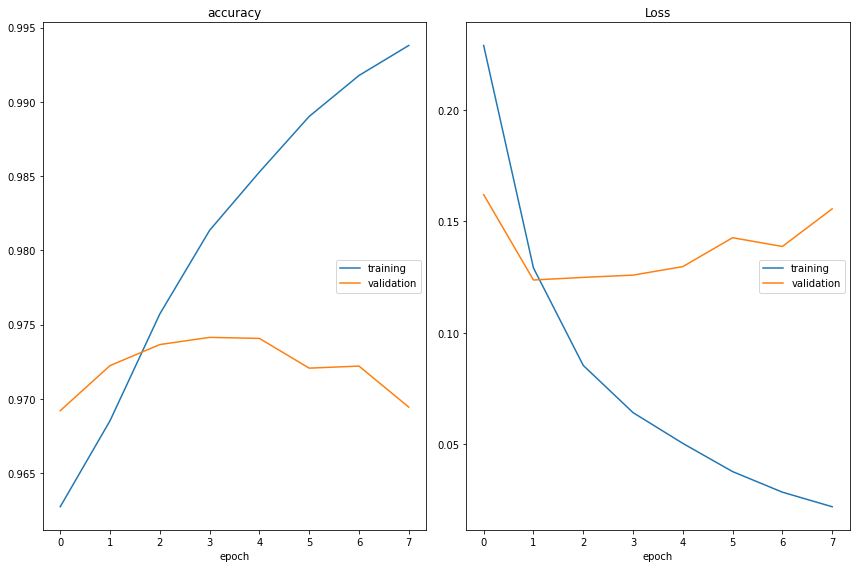

accuracy
	training         	 (min:    0.963, max:    0.994, cur:    0.994)
	validation       	 (min:    0.969, max:    0.974, cur:    0.969)
Loss
	training         	 (min:    0.022, max:    0.229, cur:    0.022)
	validation       	 (min:    0.124, max:    0.162, cur:    0.156)
232/232 [==============================] - 48s 206ms/step - loss: 0.0220 - accuracy: 0.9938 - val_loss: 0.1556 - val_accuracy: 0.9694
processed 12534 tokens with 604 phrases; found: 440 phrases; correct: 183.

precision:  41.59%; recall:  30.30%; F1:  35.06

	     company: precision:   48.08%; recall:   29.76%; F1:   36.76; predicted:    52

	    facility: precision:   37.50%; recall:   31.91%; F1:   34.48; predicted:    40

	     geo-loc: precision:   51.09%; recall:   56.97%; F1:   53.87; predicted:   184

	       movie: precision:    0.00%; recall:    0.00%; F1:    0.00; predicted:     0

	 musicartist: precision:    0.00%; recall:    0.00%; F1:    0.00; predicted:     0

	       other: precision:   28.79%; re

In [28]:
#train  and evalute model1
# early_stopping  = EarlyStopping(monitor='val_accuracy', patience=6, mode='max',restore_best_weights=True)
# callbacks=[early_stopping, PlotLossesKeras()]
history = model1.fit(
    X_train, y_train,
    validation_data=(X_validation,y_validation),
    batch_size=25,
    epochs=3,
)
evaluate(model1)


In [35]:
# train and evaluate others models
for k,v in models.items():
    print("----"*20+k+"----"*20)
    m_temp = v
    history = m_temp.fit(
        X_train, y_train,
        validation_data=(X_validation, y_validation),
        batch_size=120,
        epochs=30,
        callbacks=[early_stopping])
    evaluate(m_temp)
    models[k] = m_temp
    print("-------"*50)


--------------------------------------------------------------------------------sgd--------------------------------------------------------------------------------
Epoch 1/30
49/49 [==============================] - 31s 624ms/step - loss: 0.3570 - accuracy: 0.9671 - val_loss: 0.2685 - val_accuracy: 0.9692
Epoch 2/30
49/49 [==============================] - 31s 623ms/step - loss: 0.2688 - accuracy: 0.9671 - val_loss: 0.2454 - val_accuracy: 0.9692
Epoch 3/30
49/49 [==============================] - 31s 626ms/step - loss: 0.2573 - accuracy: 0.9671 - val_loss: 0.2393 - val_accuracy: 0.9692
Epoch 4/30
49/49 [==============================] - 31s 623ms/step - loss: 0.2538 - accuracy: 0.9671 - val_loss: 0.2368 - val_accuracy: 0.9692
Epoch 5/30
49/49 [==============================] - 31s 624ms/step - loss: 0.2522 - accuracy: 0.9671 - val_loss: 0.2353 - val_accuracy: 0.9692
processed 12534 tokens with 604 phrases; found: 0 phrases; correct: 0.

precision:  0.00%; recall:  0.00%; F1:  0.00

	  

In [27]:
#further train with best model1
history = model1.fit(
X_train, y_train,
validation_data=(X_validation,y_validation),
batch_size=25,
epochs=3
)
evaluate(model1)


Epoch 1/3
232/232 [==============================] - 51s 218ms/step - loss: 0.0576 - accuracy: 0.9831 - val_loss: 0.1254 - val_accuracy: 0.9736
Epoch 2/3
232/232 [==============================] - 50s 217ms/step - loss: 0.0438 - accuracy: 0.9867 - val_loss: 0.1285 - val_accuracy: 0.9730
Epoch 3/3
232/232 [==============================] - 50s 217ms/step - loss: 0.0320 - accuracy: 0.9906 - val_loss: 0.1441 - val_accuracy: 0.9741
processed 12534 tokens with 604 phrases; found: 404 phrases; correct: 200.

precision:  49.50%; recall:  33.11%; F1:  39.68

	     company: precision:   61.02%; recall:   42.86%; F1:   50.35; predicted:    59

	    facility: precision:   35.56%; recall:   34.04%; F1:   34.78; predicted:    45

	     geo-loc: precision:   71.05%; recall:   49.09%; F1:   58.06; predicted:   114

	       movie: precision:    0.00%; recall:    0.00%; F1:    0.00; predicted:    10

	 musicartist: precision:   33.33%; recall:    7.41%; F1:   12.12; predicted:     6

	       other: pre

## Evalutation

In [28]:
print('-'*20+ 'Evaluation in training set' + '-'*20)
train_results = predict(model1, train_tokens, train_tags)
print('-'*20+ 'Evaluation in validation set' + '-'*20)
validation_results = predict(model1, validation_tokens, validation_tags)
print('-'*20+ 'Evaluation in testing set' + '-'*20)
test_results = predict(model1, test_tokens, test_tags)

--------------------Evaluation in training set--------------------
processed 99983 tokens with 4489 phrases; found: 4617 phrases; correct: 3492.

precision:  75.63%; recall:  77.79%; F1:  76.70

	     company: precision:   84.25%; recall:   85.69%; F1:   84.97; predicted:   654

	    facility: precision:   71.36%; recall:   88.85%; F1:   79.15; predicted:   391

	     geo-loc: precision:   89.61%; recall:   90.96%; F1:   90.28; predicted:  1011

	       movie: precision:   18.03%; recall:   32.35%; F1:   23.16; predicted:   122

	 musicartist: precision:   33.88%; recall:   17.67%; F1:   23.23; predicted:   121

	       other: precision:   75.56%; recall:   75.96%; F1:   75.76; predicted:   761

	      person: precision:   83.26%; recall:   87.58%; F1:   85.37; predicted:   932

	     product: precision:   52.68%; recall:   58.81%; F1:   55.57; predicted:   355

	  sportsteam: precision:   61.25%; recall:   67.74%; F1:   64.33; predicted:   240

	      tvshow: precision:   26.67%; reca

In [34]:
#saving model
from tensorflow.keras.models import save_model, load_model

save_model(model1, '/content/model1_39')
#best model is located at 

INFO:tensorflow:Assets written to: /content/model1_39/assets


In [36]:
!zip -r model1_39.zip model1_39

  adding: model1_39/ (stored 0%)
  adding: model1_39/saved_model.pb (deflated 90%)
  adding: model1_39/variables/ (stored 0%)
  adding: model1_39/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: model1_39/variables/variables.index (deflated 71%)
  adding: model1_39/assets/ (stored 0%)
